In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# reading in the necessary data #

train_data = pd.read_csv("/content/drive/MyDrive/Wells Fargo Project/train_data.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Wells Fargo Project/test_data.csv")
zip_income = pd.read_csv("/content/drive/MyDrive/Wells Fargo Project/zip_income.csv")
alert_ratio1 = pd.read_csv("/content/drive/MyDrive/Wells Fargo Project/alert_ratio1.csv")
alert_ratio = pd.read_csv("/content/drive/MyDrive/Wells Fargo Project/alert_ratio.csv")

# Model Building & Feature Importance

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
# selecting certain data to use in training data set (Remember training dataset from wells fargo is labeled unlike the testing data set so this is the data actually used to train the model)#

train_col = ['TRAN_AMT', 'ACCT_PRE_TRAN_AVAIL_BAL', 'CUST_AGE',
             'OPEN_ACCT_CT', 'WF_dvc_age', 'PWD_UPDT_TS',
             'RGN_NAME','STATE_PRVNC_TXT','AUTHC_SCNDRY_STAT_TXT',
             'CUST_STATE','PH_NUM_UPDT_TS', 'TRAN_TS', 'median_income', 'mean_income', 
             'month', 'fraud_hits', 'alert_counts', 'fraud_alert_ratio','FRAUD_NONFRAUD']

X = train_data[train_col]

In [5]:
# gets state names from state abbrevation #

!pip install us
import us

s_names = list()

for abrev in X.CUST_STATE:
  abrev_str = str(abrev)
  state_name = str(us.states.lookup(abrev_str)).lower()
  s_names.append(state_name)
  
X['CUST_STATE'] = s_names 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [6]:
# gets list of states in lower case for later use #

s_list = list()

for state in us.STATES:
  s = str(state).lower()
  s_list.append(s)

In [7]:
# Determining if a customer was abroad, in state, or out of state based on where they received a text for an alert of fraud #

where = list()
i = 0
for local in list(X.STATE_PRVNC_TXT):
  if (local in s_list) and (local == X.CUST_STATE[i]):
    i += 1
    where.append('In State')
    
  elif (local in s_list) and (local != X.CUST_STATE[i]):
    i += 1
    where.append('Out of State')

  elif (local not in s_list) and (local == 'missing'):
    i += 1
    where.append('Unknown')

  elif (local not in s_list) and (local != X.CUST_STATE[i]):
    i += 1
    where.append('Abroad')
X['STATE_PRVNC_TXT'] = where

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
# One hot encoding categorical variables of the model #

X = pd.get_dummies(X,columns = ['PWD_UPDT_TS','RGN_NAME',
                            'STATE_PRVNC_TXT','AUTHC_SCNDRY_STAT_TXT',
                            'PH_NUM_UPDT_TS','month','TRAN_TS','CUST_STATE', 'CUST_AGE'])

In [9]:
# setting the target data and splitting the model into a training and testing groups #

y = X['FRAUD_NONFRAUD']
X_train, X_test, y_train, y_test = train_test_split(X[['fraud_alert_ratio','TRAN_AMT','ACCT_PRE_TRAN_AVAIL_BAL','fraud_hits','WF_dvc_age']],y, random_state = 422,test_size = .25)

In [10]:
rfc = RandomForestClassifier(max_depth = 15)
model = rfc.fit(X_train,y_train)

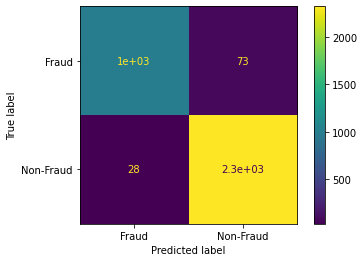

In [11]:
# confusion matrix for model #

plot_confusion_matrix(estimator = model, X= X_test, y_true= y_test)

In [12]:
# accuracy score for model #

int_score = model.score(X_test,y_test)
int_score

0.9704937189599766

In [14]:
# Generating a feature importance dataframe #

feat_imp = pd.DataFrame(columns = X_train.columns)
feat_imp.loc[len(feat_imp)] = 0

for col in X_test:

  feat_impX = X_test.copy()
  feat_impX[str(col)] = np.random.permutation(feat_impX[str(col)])
  get_score = model.score(feat_impX,y_test) 
  feat_imp[str(col)] = int_score - get_score

feat_imp.T.rename(columns = {0:'feature_importance'}).sort_values('feature_importance', ascending = False)

,feature_importance
fraud_alert_ratio,0.179375
TRAN_AMT,0.084721
ACCT_PRE_TRAN_AVAIL_BAL,0.044990
fraud_hits,0.021911
WF_dvc_age,0.018989


# Model Optimization 

The following 5 code chunks calculate validation curves for model optimization

In [15]:
param_range = [50,60,70,80,90,100]
train_score, test_score = validation_curve(RandomForestClassifier(), X = X_train, y = y_train, 
                                           param_name = 'n_estimators', param_range = param_range,
                                           scoring = 'accuracy', cv = 5)



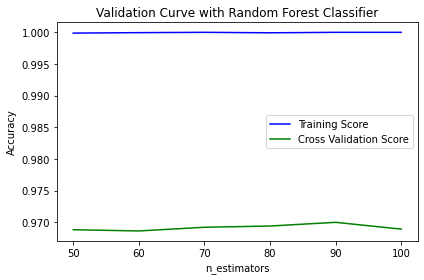

In [16]:
import matplotlib.pyplot as plt

mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)

mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)

plt.plot(param_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(param_range, mean_test_score,
   label = "Cross Validation Score", color = 'g')

plt.title("Validation Curve with Random Forest Classifier")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

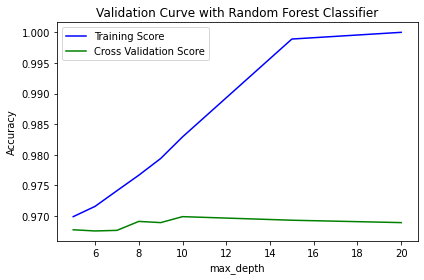

In [17]:
param_range = [5,6,7,8,9,10,15,20]
train_score, test_score = validation_curve(RandomForestClassifier(), X = X_train, y = y_train, 
                                           param_name = 'max_depth', param_range = param_range,
                                           scoring = 'accuracy', cv = 5)

mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)

mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)

plt.plot(param_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(param_range, mean_test_score,
   label = "Cross Validation Score", color = 'g')

plt.title("Validation Curve with Random Forest Classifier")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

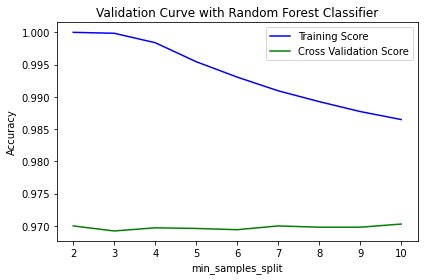

In [18]:
param_range = [1,2,3,4,5,6,7,8,9,10]
train_score, test_score = validation_curve(RandomForestClassifier(), X = X_train, y = y_train, 
                                           param_name = 'min_samples_split', param_range = param_range,
                                           scoring = 'accuracy', cv = 5)

mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)

mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)

plt.plot(param_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(param_range, mean_test_score,
   label = "Cross Validation Score", color = 'g')

plt.title("Validation Curve with Random Forest Classifier")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

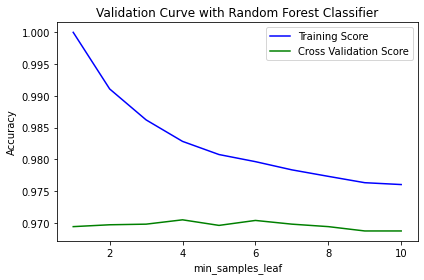

In [19]:
param_range = [1,2,3,4,5,6,7,8,9,10]
train_score, test_score = validation_curve(RandomForestClassifier(), X = X_train, y = y_train, 
                                           param_name = 'min_samples_leaf', param_range = param_range,
                                           scoring = 'accuracy', cv = 5)

mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)

mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)

plt.plot(param_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(param_range, mean_test_score,
   label = "Cross Validation Score", color = 'g')

plt.title("Validation Curve with Random Forest Classifier")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on 

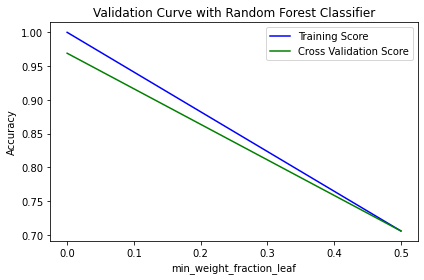

In [20]:
param_range = [0.0,.5,1.5,2.0,2.5,3.0]
train_score, test_score = validation_curve(RandomForestClassifier(), X = X_train, y = y_train, 
                                           param_name = 'min_weight_fraction_leaf', param_range = param_range,
                                           scoring = 'accuracy', cv = 5)

mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)

mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)

plt.plot(param_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(param_range, mean_test_score,
   label = "Cross Validation Score", color = 'g')

plt.title("Validation Curve with Random Forest Classifier")
plt.xlabel("min_weight_fraction_leaf")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [ ]:
# Cycles through ever single possible combination of the data parameters untila model with a score that meets the if conditional included in the code is met #

params = [i for i in X.columns if i != 'FRAUD_NONFRAUD']

from itertools import combinations

a = combinations(params,5)
combs = pd.DataFrame()

for i in a:
    
    var_comb = list(i)
    X_train, X_test, y_train, y_test = train_test_split(X[var_comb],y, random_state = 422,test_size = .25)
    rfc_opt = RandomForestClassifier()
    m = rfc_opt.fit(X_train,y_train) 
    score = m.score(X_test,y_test)
    comb =  pd.concat([pd.Series(str(var_comb)),pd.Series(score)],axis = 1).reset_index()
    combs = pd.concat([combs,comb],axis = 0)
    print('comb',var_comb,'\t','score',score)
    if (score >= .9710) & (score <= 1.0):
        break
    

combs.rename(columns = {0:'combs',1:'score'}).sort_values('score',ascending = False)

In [23]:
# Gets F1 score for the model #

from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
y_pred = list(np.where(y_pred == 'Non-Fraud',0,1))
y_test = np.where(y_test == 'Non-Fraud',0,1)

f1_score(y_test,y_pred)

0.9519276534983342